# Driving in Circles

AutomotiveDrivingModels is templated to efficiently run different types of simulations.
Entities are parameterized by their:

- *S* state, which changes over time
- *D* defintion, which does not change over time
- *I* id, typically an `Int`, which uniquely identifies that entity.

In addition to these types, the actions, environment and the driver models can also be parameterized.

This notebook demonstrates a 2D driving simulation where cars drive in a multi-lane stadium.
The types are:

- *S* - `RoadwayState`, containing both the global and lane-relative position, lane tag, and speed
- *D* - `BoundingBoxDef`, containing length, width, and class
- *I* - `Int`

We use a `Roadway` as our environment. The `Roadway` type is based on the RNDF format.

In [1]:
using AutomotiveDrivingModels
using AutoViz

INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.6/AutomotiveDrivingModels.ji for module AutomotiveDrivingModels.
INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.6/AutoViz.ji for module AutoViz.


We generate a 3-lane stadium roadway:

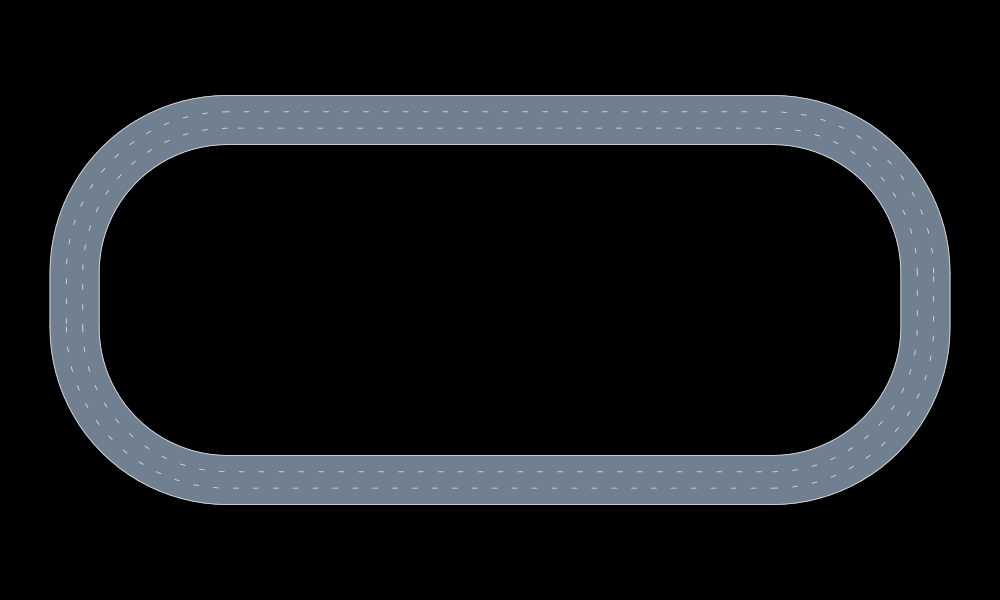

In [2]:
roadway = gen_stadium_roadway(3)

Let's populate a scene.

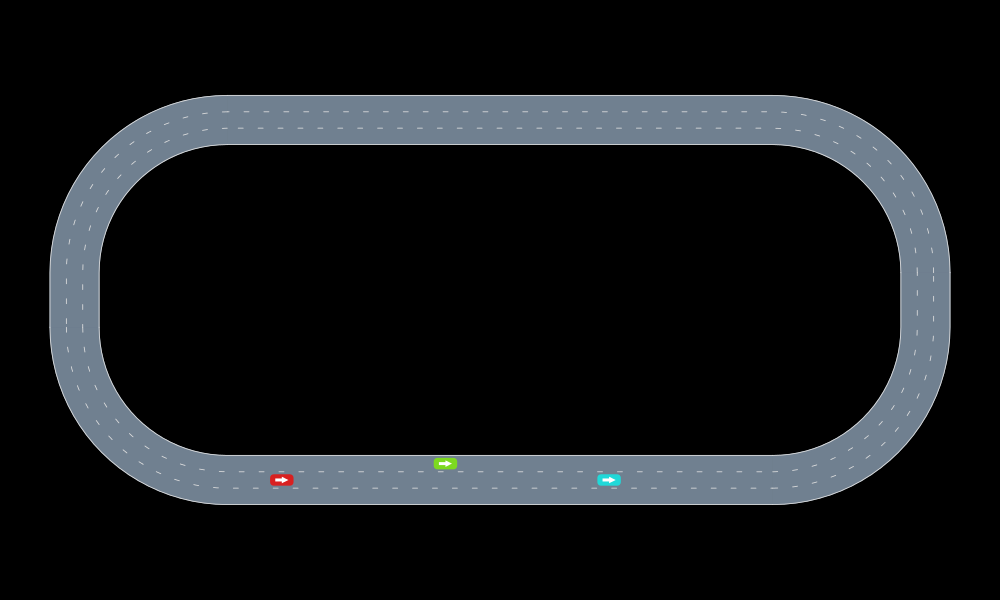

In [3]:
scene = Scene()
push!(scene,Vehicle(RoadwayState(VecSE2(10.0,-DEFAULT_LANE_WIDTH,0.0), roadway, 29.0), BoundingBoxDef(), 1))
push!(scene,Vehicle(RoadwayState(VecSE2(40.0,0.0,0.0), roadway, 22.0), BoundingBoxDef(), 2))
push!(scene,Vehicle(RoadwayState(VecSE2(70.0,-DEFAULT_LANE_WIDTH,0.0), roadway, 27.0), BoundingBoxDef(), 3))

car_colors = get_pastel_car_colors(scene)
cam = FitToContentCamera()
render(scene, roadway, cam=cam, car_colors=car_colors)

Next we assign driver models.

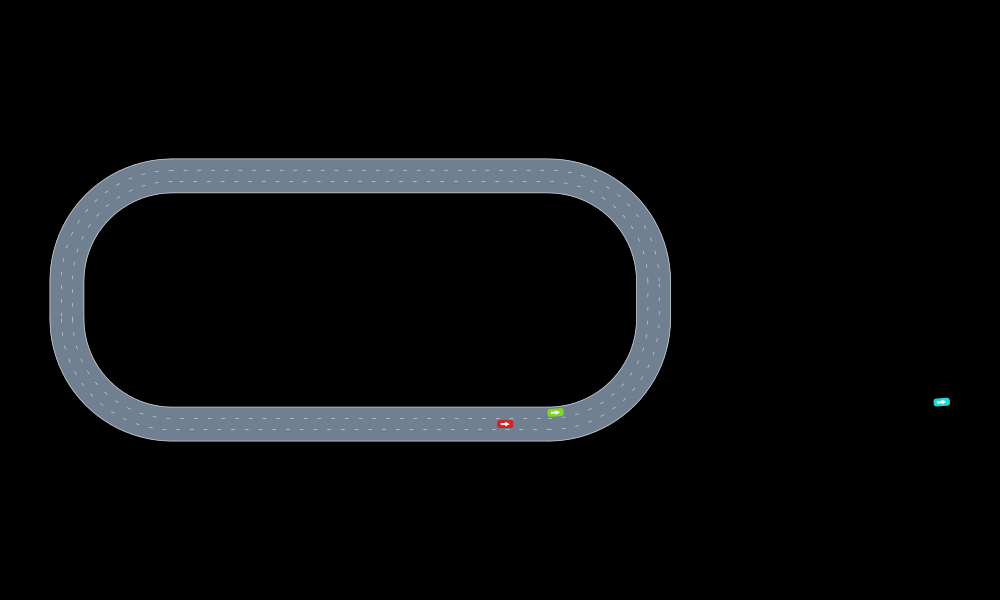

In [4]:
timestep = 0.1

models = Dict{Int, DriverModel}()
models[1] = LatLonSeparableDriver( # produces LatLonAccels
        ProportionalLaneTracker(), # lateral model
        IntelligentDriverModel(), # longitudinal model
)
models[2] = Tim2DDriver(
        mlane = MOBIL(),
    )
models[3] = StaticDriver{AccelTurnrate, MvNormal}(MvNormal([0.0,0.0], [1.0,0.1]))

set_desired_speed!(models[1], 12.0)
set_desired_speed!(models[2], 10.0)

nticks = 50
rec = QueueRecord(Vehicle, nticks+1, timestep)
simulate!(rec, scene, roadway, models, nticks)
render(rec[0], roadway, cam=cam, car_colors=car_colors)

We can use interact to inspect the simulation record. Note that the static driver just drives off the road.

Interact.Options{:SelectionSlider,Any}(1: "input" = 26 Any , "frame_index", 26, "26", 26, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(2, "2"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(39, "39"),Pair{Any,Any}(46, "46"),Pair{Any,Any}(25, "25"),Pair{Any,Any}(42, "42"),Pair{Any,Any}(29, "29"),Pair{Any,Any}(8, "8"),Pair{Any,Any}(20, "20"),Pair{Any,Any}(14, "14")…)), Any[], Any[], true, "horizontal")

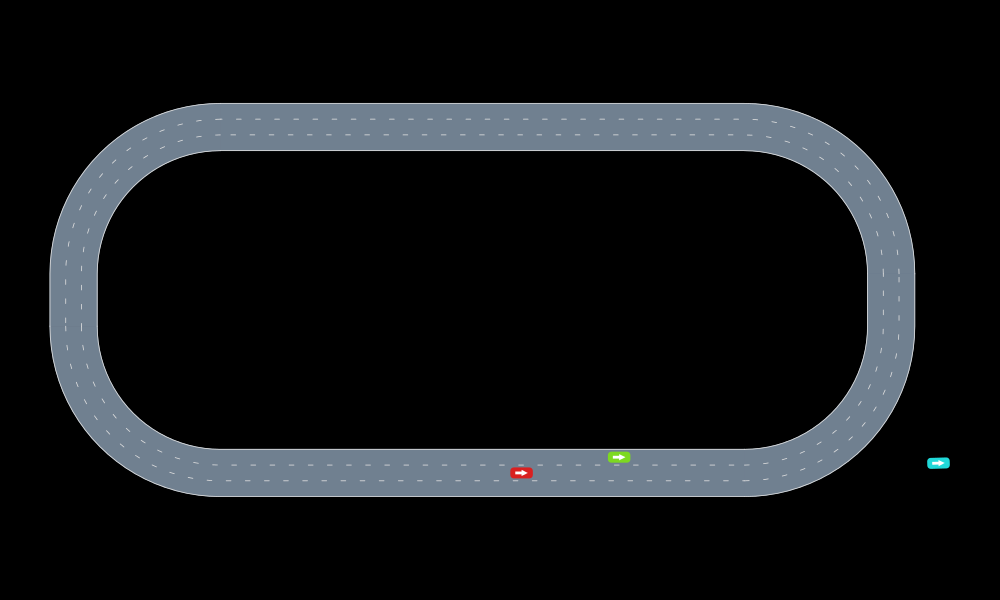

In [5]:
# using Interact
# @manipulate for frame_index in 1 : nframes(rec)
#     render(rec[frame_index-nframes(rec)], roadway, cam=cam, car_colors=car_colors)
# end

We can save the run to a text file. We achieve this by first converting the the `Trajdata` type and then exporting that.

In [6]:
listrec = convert(Trajdata, rec)
open("2Dstadium_listrec.txt", "w") do io
    write(io, MIME"text/plain"(), listrec)
end

The file can be loaded in a similar way.

In [7]:
listrec2 = open("2Dstadium_listrec.txt", "r") do io
    read(io, MIME"text/plain"(), Trajdata)
end

ListRecord{AutomotiveDrivingModels.RoadwayState, AutomotiveDrivingModels.BoundingBoxDef, Int64}(51 frames)